# Set Up
Set up the Google Colab environment and import dependent libraries.

In [13]:
#Loading data from Google drive
import os

try:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir("/content/drive/My Drive/PAN14_Code")
  RUNNING_COLAB = True
except ImportError:
  print("I have a sneaking suspicion that I'm not running on Google Colab")
  RUNNING_COLAB = False


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Lambda to print module versions
ver = lambda module : print(f"{module.__name__}=={module.__version__}")

In [15]:
import json
import math
import csv
import numpy as np
import glob
import pickle
import itertools
from collections import Counter
ver(np)

#pip install nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download(["punkt", "stopwords","wordnet"])
ver(nltk)

#pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import EarlyStopping
ver(tf)

#pip install gensim
import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
ver(gensim)

#pip install scikit-learn
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from collections import defaultdict

#pip install networkx
import networkx as nx
import random
from tqdm import tqdm
from urllib.request import urlretrieve
ver(nx)

#pip install matplotlib
import matplotlib.pyplot as plt
import string

numpy==1.23.5
nltk==3.8.1
tensorflow==2.12.0
gensim==4.3.1
networkx==3.1


In [16]:
def nltk_setup(path = None):
  """Initialize and download the right modules"""
  if path == None:
    # No change to default path (defaults to user home directory)
    nltk.download(["punkt", "stopwords","wordnet"])
  else:
    # Change default path
    nltk.data.path.insert(path, 0)
    nltk.download(["punkt", "stopwords","wordnet"], download_dir=nltk.data.path[0])

if RUNNING_COLAB:
  nltk_setup()
else:
  nltk_setup(os.curdir())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
def print_colab_stats():
  # GPU info
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)

  # Memory Info
  from psutil import virtual_memory
  ram_gb = virtual_memory().total / 1e9
  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

  if ram_gb < 20:
    print('Not using a high-RAM runtime')
  else:
    print('You are using a high-RAM runtime!')

if RUNNING_COLAB: print_colab_stats()

Wed Aug 30 19:12:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data Process
Read the data in and save it in the dict.

In [18]:
def get_data_directory_path(subdirectory):
    return os.path.join('data', subdirectory)


def get_json_file_path(data_directory, file_name):
    return os.path.join(data_directory, file_name)


def read_json_file(file_path):
    with open(file_path) as file:
        data = json.load(file)
    return data


def extract_text_from_files(file_paths):
    known_text, unknown_text = [], []

    for file_path in file_paths:
        text_lines = []
        with open(file_path, 'r') as file:
            for line in file:
                cleaned_line = line.strip().lstrip("\ufeff")
                text_lines.append(cleaned_line)
        if 'unknown' in file_path:
            unknown_text.append(text_lines)
        else:
            known_text.append(text_lines)

    return known_text, unknown_text


def build_corpus(data_directory, content_data, label_data):
    corpus = {}

    for index in tqdm(range(len(content_data['problems']))):
        problem_file_paths = glob.glob(os.path.join(data_directory, content_data['problems'][index], '*'))

        if not problem_file_paths:
            continue

        known_text, unknown_text = extract_text_from_files(problem_file_paths)
        label = 1 if label_data['problems'][index]['answer'] == 'Y' else 0

        corpus[index] = {
            'known': known_text,
            'unknown': unknown_text,
            'label': label
        }

    return corpus

In [19]:
# Get data path
train_data_directory = get_data_directory_path('train_data')
# validation_data_directory = get_data_directory_path('val_data')
test_data_directory = get_data_directory_path('test_data')

In [20]:
# Train
train_content = read_json_file(get_json_file_path(train_data_directory, 'contents.json'))
train_labels = read_json_file(get_json_file_path(train_data_directory, 'truth.json'))
# # Val
# validation_content = read_json_file(get_json_file_path(validation_data_directory, 'contents.json'))
# validation_labels = read_json_file(get_json_file_path(validation_data_directory, 'truth.json'))
# Test
test_content = read_json_file(get_json_file_path(test_data_directory, 'contents.json'))
test_labels = read_json_file(get_json_file_path(test_data_directory, 'truth.json'))

In [21]:
# Get train corpus
train_corpus = build_corpus(train_data_directory, train_content, train_labels)
# # Get val corpus
# val_corpus = build_corpus(validation_data_directory, validation_content, validation_labels)
# Get test corpus
test_corpus = build_corpus(test_data_directory, test_content, test_labels)

100%|██████████| 200/200 [05:27<00:00,  1.64s/it]


In [22]:
X_idx = []
Y_idx = []

for k,v in train_corpus.items():
  X_idx.append(k)
  Y_idx.append(v['label'])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_idx, Y_idx, test_size=0.2, random_state=42)

In [24]:
X_1, X_2 = {}, {}

for i in range(len(X_train)):
  X_1[X_train[i]] = train_corpus[X_train[i]]

for i in range(len(X_test)):
  X_2[X_test[i]] = train_corpus[X_test[i]]

In [25]:
train_corpus = X_1
val_corpus = X_2

# Train Word2Vec Model

In [26]:
def preprocess_text(text):
    """
    Preprocess a given text by tokenizing, removing punctuation and numbers,
    removing stop words, and lemmatizing.

    Args:
        text (str): The text to preprocess.

    Returns:
        list: The preprocessed text as a list of tokens.
    """
    if not isinstance(text, str):
        text = str(text)

    # Tokenize the text into words
    tokens = word_tokenize(text.lower())

    # Remove punctuation and numbers
    table = str.maketrans('', '', string.punctuation + string.digits)
    tokens = [word.translate(table) for word in tokens]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if (not word in stop_words) and (word != '')]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

def train_word2vec_model(data, vector_size):
    """
    Train a word2vec model using the given data.

    Args:
        data (dict): The data to use for training the model.
        vector_size (int): The size of the word vectors in the model.

    Returns:
        gensim.models.Word2Vec: The trained word2vec model.
    """
    corpus = []

    # Process all articles in the data
    for articles in tqdm(data.values(), total=len(data)):
        all_articles = []
        all_articles.extend(articles['known'])
        all_articles.extend(articles['unknown'])

        for article in all_articles:
            for line in article:
                text = line.strip()
                tokens = preprocess_text(text)
                corpus.append(tokens)

    # Train the word2vec model
    word2vec_model = gensim.models.Word2Vec(vector_size=vector_size, window=5, min_count=1, workers=4)
    word2vec_model.build_vocab(corpus)
    word2vec_model.train(corpus, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)

    return word2vec_model

In [27]:
# Size of word vectors in the word2vec model
w2v_vector_size = 300

In [28]:
# Train a word2vec model using the training corpus
word2vec_model = train_word2vec_model(train_corpus, w2v_vector_size)

100%|██████████| 154/154 [00:09<00:00, 16.66it/s]


# Vectorize Text Data

In [29]:
def convert_text_to_vector(texts, model):
    """
    Convert a list of texts into their corresponding word2vec vectors
    """
    vectors = []
    for text in texts:
        words = preprocess_text(text)
        vector = np.sum([model.wv[word] for word in words if word in model.wv], axis=0)
        word_count = np.sum([word in model.wv for word in words])
        if word_count != 0:
            vector /= word_count
        else:
          vector = np.zeros(w2v_vector_size)
        vectors.append(vector)
    return vectors

In [30]:
def count_punctuations(texts):
  """
  Count the frequency of different punctuations in the texts
  """
  # Define punctuations to count
  punctuations = set(['.', ',', ';', ':', '!', '?', '-', '(', ')', '\"', '\'', '`', '/'])

  # Initialize dictionary to count punctuations
  punctuations_count = {p: 0 for p in punctuations}

  # Count punctuations in text_list
  for text in texts:
      for char in text:
          if char in punctuations:
              punctuations_count[char] += 1

  # Return list of punctuation counts
  return list(punctuations_count.values())

In [31]:
def analyze_sentence_lengths(sentences):
  """
  Analyze the lengths of sentences
  """
  sentence_lengths = [len(sentence.split()) for sentence in sentences]
  average_length = np.mean(sentence_lengths)
  count_over_avg = np.sum([length > average_length for length in sentence_lengths])
  count_under_avg = np.sum([length < average_length for length in sentence_lengths])
  count_avg = len(sentence_lengths) - count_over_avg - count_under_avg

  return [count_over_avg, count_under_avg, count_avg, average_length]

In [32]:
def analyze_words(texts):
    """
    Analyze the words used in the texts
    """
    words = []
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    for text in texts:
        tokenized = word_tokenize(text.lower())
        processed = [lemmatizer.lemmatize(word) for word in tokenized if word not in stop_words]
        words += processed
    word_freq = nltk.FreqDist(words)
    rare_count = np.sum([freq <= 2 for word, freq in word_freq.items()])
    long_count = np.sum([len(word) > 6 for word in words])
    word_lengths = [len(word) for word in words]
    average_length = np.mean(word_lengths)
    count_over_avg = np.sum([length > average_length for length in word_lengths])
    count_under_avg = np.sum([length < average_length for length in word_lengths])
    count_avg = len(word_lengths) - count_over_avg - count_under_avg
    ttr = len(set(words)) / len(words) if words else 0

    return [rare_count, long_count, count_over_avg, count_under_avg, count_avg, ttr]

In [33]:
def calculate_style_vector(texts):
  """
  Calculate the style vector of the texts
  """
  punctuation_vec = count_punctuations(texts)     # Punctuations stylistic features
  sentence_vec = analyze_sentence_lengths(texts)  # Sentences stylistic features
  word_vec = analyze_words(texts)                 # Words stylistic features
  word_count = np.sum([len(text.split()) for text in texts])

  vector = np.concatenate((punctuation_vec, sentence_vec, word_vec))

  return vector / word_count if word_count else vector

In [34]:
def get_vectors(texts, w2v_model):
  res = []
  for text in texts:
    w2v_vec = np.mean(convert_text_to_vector(text, w2v_model), axis=0)
    style_vec = calculate_style_vector(text)
    res.append(np.concatenate((w2v_vec, style_vec), axis=None))
    # res.append(w2v_vec)

  return res

In [35]:
def vectorize_text_data(data, w2v_model):
  """
  Build author data from the corpus
  """
  res = {}
  for key,val in tqdm(data.items(), total=len(data)):
    if len(val['unknown']) == 0:
      continue
    res[key] = {
        'known': get_vectors(val['known'], w2v_model),
        'unknown': get_vectors(val['unknown'], w2v_model),
        'label': val['label']
    }

  return res

In [36]:
train_data = vectorize_text_data(train_corpus, word2vec_model)
val_data = vectorize_text_data(val_corpus, word2vec_model)
test_data = vectorize_text_data(test_corpus, word2vec_model)

100%|██████████| 200/200 [00:22<00:00,  9.01it/s]


# Build Triplet Samples

In [37]:
# Random triplet mining
def build_random_triplet_sample(data):
  """
  This function creates random triplet samples from the input data
  """

  keys_list = list(data.keys())
  triplet_samples = {}

  # Initialize the lists for storing the anchor, positive, and negative samples
  anchors, positives, negatives = [], [], []

  for key,val in tqdm(data.items(), total=len(data)):
    n = len(val['known'])
    for i in range(n):
      for j in range(i+1, n):
        anchors.append(val['known'][i])
        positives.append(val['known'][j])
        # Get negative sample
        while True:
          random_key = random.choices(keys_list, k=1)
          if random_key != key:
            break
        random_neg_sample = random.choices(data[random_key[0]]['known'], k=1)
        negatives.append(random_neg_sample[0])


  # Build triplet sample
  for i in range(len(anchors)):
    triplet_samples[i] = {
        'anchor': anchors[i],
        'positive': positives[i],
        'negative': negatives[i]
    }

  return triplet_samples

In [38]:
random_triplet_samples = build_random_triplet_sample(train_data)

100%|██████████| 152/152 [00:00<00:00, 94842.93it/s]


In [39]:
anchor_data = np.array([data['anchor'] for data in random_triplet_samples.values()])
positive_data = np.array([data['positive'] for data in random_triplet_samples.values()])
negative_data = np.array([data['negative'] for data in random_triplet_samples.values()])
labels_data = np.array([0 for _ in random_triplet_samples.values()])

In [40]:
val_random_triplet_samples = build_random_triplet_sample(val_data)

100%|██████████| 39/39 [00:00<00:00, 90175.22it/s]


In [41]:
val_anchor_data = np.array([data['anchor'] for data in val_random_triplet_samples.values()])
val_positive_data = np.array([data['positive'] for data in val_random_triplet_samples.values()])
val_negative_data = np.array([data['negative'] for data in val_random_triplet_samples.values()])
val_labels_data = np.array([0 for _ in val_random_triplet_samples.values()])

# Build SiameseNet Model

## Model Frame

In [42]:
class SiameseNet(tf.keras.Model):
    def __init__(self, base_network, clf_network):
        super().__init__()
        self.base = base_network
        self.clf = clf_network

    def call(self, inputs):
        anchor = inputs[0]
        positive = inputs[1]
        negative = inputs[2]

        output_anchor = self.base(anchor)
        output_positive = self.base(positive)
        output_negative = self.base(negative)

        # Anchor - Positive
        x1 = tf.concat([output_anchor, output_positive], axis=-1)
        x1_out = self.clf(x1)

        # Anchor - Negative
        x2 = tf.concat([output_anchor, output_negative], axis=-1)
        x2_out = self.clf(x2)

        return (x1_out, x2_out)

In [43]:
def create_dense_block(x, units, dropout_rate, l1_reg, l2_reg):
    x = tf.keras.layers.Dense(units, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return tf.keras.layers.Dropout(dropout_rate)(x)

In [44]:
# Define the base network
def create_base_network(embedding_dim, dropout_rate=0.4, l1_reg=0.001, l2_reg=0.001):
    input = tf.keras.layers.Input(shape=embedding_dim)
    x = tf.keras.layers.BatchNormalization()(input)

    x = create_dense_block(x, 256, dropout_rate, l1_reg, l2_reg)
    x = create_dense_block(x, 128, dropout_rate, l1_reg, l2_reg)
    x = create_dense_block(x, 64, dropout_rate, l1_reg, l2_reg)

    x = tf.keras.layers.Dense(64, activation='linear')(x)

    return tf.keras.Model(inputs=input, outputs=x)

In [45]:
def create_clf_network(input_shape, dropout_rate=0.5, l1_reg=0.003, l2_reg=0.003):
    input = tf.keras.layers.Input(shape=(input_shape,))
    x = tf.keras.layers.BatchNormalization()(input)

    x = create_dense_block(x, 128, dropout_rate, l1_reg, l2_reg)
    x = create_dense_block(x, 64, dropout_rate, l1_reg, l2_reg)
    x = create_dense_block(x, 32, dropout_rate, l1_reg, l2_reg)

    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=input, outputs=x)


In [46]:
def customer_loss(y_true, y_pred):
    AP = y_pred[0]
    AN = y_pred[1]

    loss = 1.0 - AP + AN

    return loss

## Construct the Model

In [47]:
# Define the embedding dimension
embedding_dim = anchor_data[0].shape

# Create base network
base_network = create_base_network(embedding_dim)
clf_network = create_clf_network(base_network.output_shape[1]*2)

siamese_model = SiameseNet(base_network, clf_network)

In [48]:
input_anchor = tf.keras.layers.Input(shape=embedding_dim)
input_positive = tf.keras.layers.Input(shape=embedding_dim)
input_negative = tf.keras.layers.Input(shape=embedding_dim)

In [49]:
# Assemble siameseNet model
siamese_model.compile(optimizer='adam',
                      loss=customer_loss)

In [50]:
checkpoint_path = "model_weights/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_save = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                             save_weights_only=True,
                                             verbose=1)

## Load SiameseNet Model Weights

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
siamese_model.load_weights(latest)

## Train SiameseNet Model

### Train on Random Triplet Samples

In [51]:
# Train siameseNet model
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1)
siamese_history = siamese_model.fit([anchor_data, positive_data, negative_data], labels_data,
                  epochs=1000,
                  validation_data=([val_anchor_data, val_positive_data, val_negative_data], val_labels_data),
                  callbacks=[early_stopping, cp_save])

Epoch 1/1000
13/15 [=========================>....] - ETA: 0s - loss: 17.0379 - output_1_loss: 1.0511 - output_2_loss: 1.0863
Epoch 1: saving model to model_weights/cp.ckpt
15/15 [==============================] - 16s 77ms/step - loss: 17.0093 - output_1_loss: 1.0365 - output_2_loss: 1.0824 - val_loss: 16.7834 - val_output_1_loss: 1.0001 - val_output_2_loss: 0.9997
Epoch 2/1000
13/15 [=========================>....] - ETA: 0s - loss: 16.5693 - output_1_loss: 0.7600 - output_2_loss: 1.0963
Epoch 2: saving model to model_weights/cp.ckpt
15/15 [==============================] - 0s 26ms/step - loss: 16.5719 - output_1_loss: 0.7595 - output_2_loss: 1.1083 - val_loss: 16.6044 - val_output_1_loss: 0.9973 - val_output_2_loss: 1.0012
Epoch 3/1000
13/15 [=========================>....] - ETA: 0s - loss: 16.6376 - output_1_loss: 0.9439 - output_2_loss: 1.1600
Epoch 3: saving model to model_weights/cp.ckpt
15/15 [==============================] - 0s 29ms/step - loss: 16.5998 - output_1_loss: 0.923

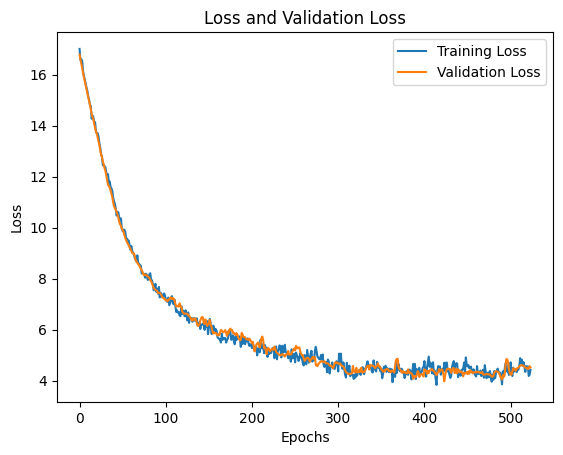

In [52]:
loss = siamese_history.history['loss']
val_loss = siamese_history.history['val_loss']

# Draw
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Train on Semi-Hard Triplet Samples

#### Semi-Hard Samples Construct

In [53]:
# Build semi-hard triplet sample candidates
def build_triplet_sample_candidates(data):
  res = {}

  keys = []
  anchors = []
  positives = []

  for key,val in tqdm(data.items(), total=len(data)):
    n = len(val['known'])
    for i in range(n-1):
      keys.append(key)
      anchors.append(val['known'][i])
      positives.append(val['known'][i+1:])

  for i in range(len(keys)):
    res[i] = {
        'key': keys[i],
        'anchor': anchors[i],
        'positives': positives[i]
    }

  return res

In [54]:
triplet_sample_candidates = build_triplet_sample_candidates(train_data)

100%|██████████| 152/152 [00:00<00:00, 99614.72it/s]


In [55]:
def create_negative_vectors_dict(data):
    negative_vectors_dict = {}
    key_list = list(data.keys())

    for key in tqdm(key_list, total=len(key_list)):
        negative_vectors_dict[key] = []
        for k,v in data.items():
            if k != key:
                for vec in v['known']:
                    negative_vectors_dict[key].append(vec)
    return negative_vectors_dict

In [56]:
negative_vectors_dict = create_negative_vectors_dict(train_data)

100%|██████████| 152/152 [00:00<00:00, 9240.83it/s]


In [57]:
def select_random_from_list(input_list):
    """
    Selects a random item from a list.
    """
    return input_list[np.random.randint(0, len(input_list))]

# def select_negative_vectors(negatives, key):
#     """
#     Collects all negative vectors except for the one corresponding to the key.
#     """
#     return [vec for k,v in negatives.items() if k != key for vec in v['known']]

def get_random_triplet(sample, negatives):
    """
    This function takes a sample and negatives, and returns a random triplet of anchor, positive, and negative.
    """
    # Select the positive vector
    positive = select_random_from_list(sample['positives'])

    # Select the negative vector
    negative = select_random_from_list(negatives[sample['key']])

    return sample['anchor'], positive, negative

def get_hard_triplet(sample, negatives, base_model, clf_model,):
    """
    This function takes a sample, negatives, and a model, and returns a hard triplet of anchor, positive, and negative.
    The sample with the lowest probability is the hardest positive sample,
    while a high probability indicates that the model is confident in classifying it as positive.
    Therefore, the lowest probability implies that the model has incorrectly classified it.
    """
    anchor_rep = base_model.predict(np.array([sample['anchor']]), verbose=0)

    ### ------ Positive ------ ###
    # Compute distances between anchor and all positive vectors
    positive_reps = base_model.predict(np.array(sample['positives']), verbose=0)
    AP_reps = []
    for rep in positive_reps:
        comb = np.concatenate((anchor_rep[0], rep), axis=None)
        AP_reps.append(comb)

    # Select the hardest positive (the one with the lowest probability)
    positive_distances = clf_model.predict(np.array(AP_reps), verbose=0)
    hardest_positive = sample['positives'][np.argmin(positive_distances)]


    ### ------ Negative ------ ###
    # Collect all negative vectors and compute distances to anchor
    negative_vectors = negatives[sample['key']]
    negative_reps = base_model.predict(np.array(negative_vectors), verbose=0)
    AN_reps = []
    for rep in negative_reps:
        comb = np.concatenate((anchor_rep[0], rep), axis=None)
        AN_reps.append(comb)

    # Select the hardest negative (the one with the highest probability)
    negative_distances = clf_model.predict(np.array(AN_reps), verbose=0)
    hardest_negative = negative_vectors[np.argmax(negative_distances)]

    # # positive_distances = [compute_cosine_distance(pos_rep, anchor_rep[0]) for pos_rep in positive_reps]
    # positive_distances = [np.sum(np.square(pos_rep - anchor_rep[0])) for pos_rep in positive_reps]

    # # Select the hardest positive (the one with the largest distance)
    # hardest_positive = sample['positives'][np.argmax(positive_distances)]

    # # Collect all negative vectors and compute distances to anchor
    # negative_vectors = select_negative_vectors(negatives, sample['key'])
    # negative_reps = model.predict(np.array(negative_vectors), verbose=0)
    # negative_distances = [np.sum(np.square(neg_rep - anchor_rep[0])) for neg_rep in negative_reps]

    # # Select the hardest negative (the one with the smallest distance)
    # hardest_negative = negative_vectors[np.argmin(negative_distances)]

    return sample['anchor'], hardest_positive, hardest_negative

def get_triplet(sample, negatives, base_model, clf_model, hard_triplet_probability):
    """
    This function decides between selecting a hard triplet or a random triplet based on the hard_triplet_probability.
    """
    if np.random.rand() < hard_triplet_probability:
        # With a certain probability, choose the hardest triplet
        return get_hard_triplet(sample, negatives, base_model, clf_model)
    else:
        # Otherwise, choose a random triplet
        return get_random_triplet(sample, negatives)


#### Training on Semi-Hard Samples

In [58]:
num_epochs = 100
patience = 10
previous_loss = float('inf')

hard_triplet_probability_start=0.5
hard_triplet_probability_end=0.8

early_stopping_2 = EarlyStopping(monitor='loss', patience=patience, verbose=0)

In [59]:
# Initial probability of selecting a hard triplet
triplet_select_probability = hard_triplet_probability_start

# Iterate over each epoch
for epoch in tqdm(range(num_epochs)):
  # Initialize empty lists for anchor, positive, negative samples and labels
  anchor_samples = []
  positive_samples = []
  negative_samples = []
  labels = []

  # Iterate over triplet samples
  for _, sample in triplet_sample_candidates.items():
    # Get the anchor, positive, negative samples
    anchor, positive, negative = get_triplet(sample, negative_vectors_dict, base_network, clf_network, triplet_select_probability)
    # Add samples to their respective lists
    anchor_samples.append(anchor)
    positive_samples.append(positive)
    negative_samples.append(negative)
    labels.append(0)

  # Convert lists to numpy arrays
  anchor_samples = np.array(anchor_samples)
  positive_samples = np.array(positive_samples)
  negative_samples = np.array(negative_samples)
  labels = np.array(labels)

  # Train the model on current epoch's data
  siamese_model.fit([anchor_samples, positive_samples, negative_samples], labels,
                    epochs=50,
                    verbose=1,
                    callbacks=[early_stopping_2, cp_save])

  # Gradually increase the probability of choosing a hard triplet
  triplet_select_probability += (hard_triplet_probability_end - hard_triplet_probability_start) / num_epochs

  # Uncomment the following section for Early Stopping
  # Check if current epoch is a 'patience' epoch
  if epoch % patience == 0 and epoch != 0:
    current_loss = siamese_model.history.history['loss'][-1]
    # Check if loss is increasing or constant, if yes, then stop training
    if current_loss >= previous_loss:
      print("Early stopping triggered. Stopping training.")
      break
    else:
      # Update previous loss with current loss
      previous_loss = current_loss

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 4.3696 - output_1_loss: 0.9917 - output_2_loss: 0.9235
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 40ms/step - loss: 4.3696 - output_1_loss: 0.9917 - output_2_loss: 0.9235
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 4.2857 - output_1_loss: 0.9421 - output_2_loss: 0.9165
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 41ms/step - loss: 4.2857 - output_1_loss: 0.9421 - output_2_loss: 0.9165
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.5628 - output_1_loss: 1.0897 - output_2_loss: 1.0706
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 35ms/step - loss: 4.5434 - output_1_loss: 1.0750 - output_2_loss: 1.0711
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 4.7004 - output_1_loss: 1.2752 - output_2_loss: 1.0488
Epoch 4: saving model to model

  1%|          | 1/100 [00:41<1:09:06, 41.88s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 4.2696 - output_1_loss: 0.9328 - output_2_loss: 0.9601
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 40ms/step - loss: 4.2759 - output_1_loss: 1.0084 - output_2_loss: 0.8922
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 4.2708 - output_1_loss: 1.0196 - output_2_loss: 0.8842
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 36ms/step - loss: 4.1346 - output_1_loss: 0.9900 - output_2_loss: 0.7779
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.5383 - output_1_loss: 1.1393 - output_2_loss: 1.0346
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 37ms/step - loss: 4.3675 - output_1_loss: 1.0375 - output_2_loss: 0.9677
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 4.5527 - output_1_loss: 1.0752 - output_2_loss: 1.1284
Epoch 4: saving model to model

  2%|▏         | 2/100 [01:20<1:05:03, 39.83s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 4.3663 - output_1_loss: 1.0013 - output_2_loss: 0.9659
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 39ms/step - loss: 4.4349 - output_1_loss: 0.9876 - output_2_loss: 1.0501
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 4.2999 - output_1_loss: 1.0149 - output_2_loss: 0.8970
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 38ms/step - loss: 4.3527 - output_1_loss: 1.0334 - output_2_loss: 0.9320
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.2932 - output_1_loss: 0.9712 - output_2_loss: 0.9376
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 35ms/step - loss: 4.4369 - output_1_loss: 1.0359 - output_2_loss: 1.0173
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 4.8124 - output_1_loss: 1.3247 - output_2_loss: 1.1081
Epoch 4: saving model to model

  3%|▎         | 3/100 [02:07<1:09:40, 43.09s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 4.4626 - output_1_loss: 1.2674 - output_2_loss: 0.8592
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 40ms/step - loss: 4.3290 - output_1_loss: 1.1890 - output_2_loss: 0.8022
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 4.4456 - output_1_loss: 1.0702 - output_2_loss: 1.0382
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 34ms/step - loss: 4.4724 - output_1_loss: 1.1425 - output_2_loss: 0.9956
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.7351 - output_1_loss: 1.1674 - output_2_loss: 1.2431
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 36ms/step - loss: 4.5671 - output_1_loss: 1.0662 - output_2_loss: 1.1766
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 4.3274 - output_1_loss: 0.9987 - output_2_loss: 1.0040
Epoch 4: saving model to model

  4%|▍         | 4/100 [02:54<1:11:46, 44.86s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 4.0217 - output_1_loss: 0.9646 - output_2_loss: 0.7365
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 38ms/step - loss: 4.1345 - output_1_loss: 1.0415 - output_2_loss: 0.7743
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 4.0672 - output_1_loss: 0.9624 - output_2_loss: 0.7980
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 37ms/step - loss: 4.0610 - output_1_loss: 0.9876 - output_2_loss: 0.7699
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 3.9660 - output_1_loss: 0.8060 - output_2_loss: 0.8738
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 40ms/step - loss: 4.1639 - output_1_loss: 0.8512 - output_2_loss: 1.0302
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 4.3040 - output_1_loss: 0.9568 - output_2_loss: 1.0800
Epoch 4: saving model to model

  5%|▌         | 5/100 [03:42<1:12:27, 45.76s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 4.1074 - output_1_loss: 0.8759 - output_2_loss: 0.8748
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 39ms/step - loss: 4.1291 - output_1_loss: 0.8919 - output_2_loss: 0.8769
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 3.9840 - output_1_loss: 0.6335 - output_2_loss: 0.9763
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 43ms/step - loss: 4.1676 - output_1_loss: 0.8797 - output_2_loss: 0.9118
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.2800 - output_1_loss: 0.9582 - output_2_loss: 0.9411
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 40ms/step - loss: 4.3542 - output_1_loss: 0.8917 - output_2_loss: 1.0826
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 4.5962 - output_1_loss: 1.0758 - output_2_loss: 1.1310
Epoch 4: saving model to model

  6%|▌         | 6/100 [04:30<1:13:15, 46.76s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 4.6416 - output_1_loss: 1.1269 - output_2_loss: 1.1123
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 40ms/step - loss: 4.5512 - output_1_loss: 1.0848 - output_2_loss: 1.0635
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 4.6852 - output_1_loss: 1.0262 - output_2_loss: 1.2581
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 40ms/step - loss: 4.4471 - output_1_loss: 0.9338 - output_2_loss: 1.1131
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 4.1266 - output_1_loss: 0.9773 - output_2_loss: 0.7492
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 43ms/step - loss: 4.1266 - output_1_loss: 0.9773 - output_2_loss: 0.7492
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 4.4653 - output_1_loss: 1.0415 - output_2_loss: 1.0172
Epoch 4: saving model to model

  7%|▋         | 7/100 [05:12<1:09:53, 45.09s/it]

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 4.3103 - output_1_loss: 1.0193 - output_2_loss: 0.9570
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 42ms/step - loss: 4.3103 - output_1_loss: 1.0193 - output_2_loss: 0.9570
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 3.8645 - output_1_loss: 0.7771 - output_2_loss: 0.7424
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 42ms/step - loss: 4.2428 - output_1_loss: 0.9258 - output_2_loss: 0.9697
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.1326 - output_1_loss: 0.7671 - output_2_loss: 1.0077
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 37ms/step - loss: 4.0748 - output_1_loss: 0.7837 - output_2_loss: 0.9297
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 4.0372 - output_1_loss: 0.7778 - output_2_loss: 0.8854
Epoch 4: saving model to model

  8%|▊         | 8/100 [05:56<1:08:35, 44.73s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 4.2020 - output_1_loss: 0.8195 - output_2_loss: 1.0642
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 38ms/step - loss: 4.1233 - output_1_loss: 0.7684 - output_2_loss: 1.0319
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 4.4922 - output_1_loss: 1.0278 - output_2_loss: 1.1207
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 42ms/step - loss: 4.2355 - output_1_loss: 0.9578 - output_2_loss: 0.9324
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.3704 - output_1_loss: 1.0722 - output_2_loss: 0.9507
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 39ms/step - loss: 3.8447 - output_1_loss: 0.8112 - output_2_loss: 0.6882
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 4.2652 - output_1_loss: 1.0339 - output_2_loss: 0.8990
Epoch 4: saving model to model

  9%|▉         | 9/100 [06:44<1:09:36, 45.89s/it]

Epoch 1/50
7/8 [=========================>....] - ETA: 0s - loss: 3.9491 - output_1_loss: 0.8954 - output_2_loss: 0.8165
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 44ms/step - loss: 3.9866 - output_1_loss: 0.9261 - output_2_loss: 0.8235
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 4.0579 - output_1_loss: 0.8301 - output_2_loss: 0.9868
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 41ms/step - loss: 3.9507 - output_1_loss: 0.8344 - output_2_loss: 0.8729
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.3198 - output_1_loss: 0.9024 - output_2_loss: 1.1705
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 40ms/step - loss: 4.3912 - output_1_loss: 1.0476 - output_2_loss: 1.0990
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 3.8509 - output_1_loss: 1.0286 - output_2_loss: 0.5849
Epoch 4: saving model to model

 10%|█         | 10/100 [07:33<1:09:56, 46.62s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 4.1658 - output_1_loss: 0.9927 - output_2_loss: 1.0336
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 40ms/step - loss: 4.1034 - output_1_loss: 1.0132 - output_2_loss: 0.9517
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 4.3618 - output_1_loss: 1.1153 - output_2_loss: 1.1145
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 36ms/step - loss: 4.2642 - output_1_loss: 1.0991 - output_2_loss: 1.0346
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 4.1166 - output_1_loss: 1.0052 - output_2_loss: 0.9726
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 43ms/step - loss: 4.1166 - output_1_loss: 1.0052 - output_2_loss: 0.9726
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 3.8668 - output_1_loss: 0.5824 - output_2_loss: 1.1282
Epoch 4: saving model to model

 11%|█         | 11/100 [08:17<1:07:54, 45.78s/it]

Epoch 1/50
7/8 [=========================>....] - ETA: 0s - loss: 4.5925 - output_1_loss: 1.1660 - output_2_loss: 1.4143
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 43ms/step - loss: 4.5742 - output_1_loss: 1.2055 - output_2_loss: 1.3568
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 4.0655 - output_1_loss: 1.0781 - output_2_loss: 0.9734
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 45ms/step - loss: 4.0655 - output_1_loss: 1.0781 - output_2_loss: 0.9734
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 4.0643 - output_1_loss: 0.9906 - output_2_loss: 1.0549
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 43ms/step - loss: 4.0643 - output_1_loss: 0.9906 - output_2_loss: 1.0549
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 4.0332 - output_1_loss: 0.9998 - output_2_loss: 1.0036
Epoch 4: saving model to model

 12%|█▏        | 12/100 [09:05<1:08:25, 46.65s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 3.9863 - output_1_loss: 0.8207 - output_2_loss: 0.9175
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 37ms/step - loss: 4.1038 - output_1_loss: 0.9428 - output_2_loss: 0.9099
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 3.9974 - output_1_loss: 0.8613 - output_2_loss: 0.8803
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 40ms/step - loss: 3.8185 - output_1_loss: 0.7151 - output_2_loss: 0.8489
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.1326 - output_1_loss: 0.8470 - output_2_loss: 1.0389
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 35ms/step - loss: 4.1827 - output_1_loss: 0.8151 - output_2_loss: 1.1221
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 4.4189 - output_1_loss: 1.1235 - output_2_loss: 1.0584
Epoch 4: saving model to model

 13%|█▎        | 13/100 [09:52<1:07:41, 46.68s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 4.1625 - output_1_loss: 1.1103 - output_2_loss: 0.9675
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 40ms/step - loss: 4.3421 - output_1_loss: 1.2286 - output_2_loss: 1.0299
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 3.9679 - output_1_loss: 0.9598 - output_2_loss: 0.9266
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 42ms/step - loss: 3.8499 - output_1_loss: 0.8906 - output_2_loss: 0.8760
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 3.9995 - output_1_loss: 0.8382 - output_2_loss: 1.0669
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 38ms/step - loss: 4.0934 - output_1_loss: 0.9444 - output_2_loss: 1.0521
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 3.9205 - output_1_loss: 0.9062 - output_2_loss: 0.9046
Epoch 4: saving model to model

 14%|█▍        | 14/100 [10:44<1:09:08, 48.24s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 3.7483 - output_1_loss: 0.8704 - output_2_loss: 0.8930
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 39ms/step - loss: 3.9906 - output_1_loss: 1.0056 - output_2_loss: 1.0021
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 3.7045 - output_1_loss: 0.7105 - output_2_loss: 1.0253
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 41ms/step - loss: 3.7439 - output_1_loss: 0.7653 - output_2_loss: 1.0134
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.2283 - output_1_loss: 1.2229 - output_2_loss: 1.0606
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 40ms/step - loss: 4.2933 - output_1_loss: 1.2300 - output_2_loss: 1.1245
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 3.8941 - output_1_loss: 0.8925 - output_2_loss: 1.0931
Epoch 4: saving model to model

 15%|█▌        | 15/100 [11:27<1:06:02, 46.62s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 3.7963 - output_1_loss: 1.0494 - output_2_loss: 0.8491
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 41ms/step - loss: 3.8971 - output_1_loss: 1.0729 - output_2_loss: 0.9243
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 3.9150 - output_1_loss: 0.9915 - output_2_loss: 1.0133
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 38ms/step - loss: 4.0245 - output_1_loss: 1.0298 - output_2_loss: 1.0805
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.0203 - output_1_loss: 0.9610 - output_2_loss: 1.1161
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 42ms/step - loss: 3.8393 - output_1_loss: 0.8992 - output_2_loss: 0.9902
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 3.8997 - output_1_loss: 0.9008 - output_2_loss: 1.0177
Epoch 4: saving model to model

 16%|█▌        | 16/100 [12:13<1:05:03, 46.47s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 3.6290 - output_1_loss: 0.6335 - output_2_loss: 0.8513
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 38ms/step - loss: 3.7296 - output_1_loss: 0.7256 - output_2_loss: 0.8554
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 4.0628 - output_1_loss: 0.8114 - output_2_loss: 1.0697
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 39ms/step - loss: 4.1259 - output_1_loss: 0.9878 - output_2_loss: 0.9486
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.0945 - output_1_loss: 0.8363 - output_2_loss: 1.0418
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 40ms/step - loss: 4.1583 - output_1_loss: 0.8058 - output_2_loss: 1.1344
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 4.2013 - output_1_loss: 1.0212 - output_2_loss: 0.9507
Epoch 4: saving model to model

 17%|█▋        | 17/100 [12:58<1:03:50, 46.16s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 3.9751 - output_1_loss: 0.8323 - output_2_loss: 0.9904
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 41ms/step - loss: 3.9117 - output_1_loss: 0.8619 - output_2_loss: 0.9030
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 3.8801 - output_1_loss: 0.9284 - output_2_loss: 0.8321
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 38ms/step - loss: 3.8872 - output_1_loss: 0.9002 - output_2_loss: 0.8716
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.0371 - output_1_loss: 0.8096 - output_2_loss: 1.1275
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 38ms/step - loss: 4.0918 - output_1_loss: 0.9666 - output_2_loss: 1.0266
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 4.1293 - output_1_loss: 1.2267 - output_2_loss: 0.8120
Epoch 4: saving model to model

 18%|█▊        | 18/100 [13:41<1:01:48, 45.23s/it]

Epoch 1/50
7/8 [=========================>....] - ETA: 0s - loss: 4.4973 - output_1_loss: 1.0986 - output_2_loss: 1.0675
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 44ms/step - loss: 4.3734 - output_1_loss: 1.0171 - output_2_loss: 1.0246
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 4.2702 - output_1_loss: 0.9634 - output_2_loss: 0.9671
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 49ms/step - loss: 4.2702 - output_1_loss: 0.9634 - output_2_loss: 0.9671
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 4.5098 - output_1_loss: 0.9849 - output_2_loss: 1.1726
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 42ms/step - loss: 4.5098 - output_1_loss: 0.9849 - output_2_loss: 1.1726
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 4.7159 - output_1_loss: 1.2888 - output_2_loss: 1.0715
Epoch 4: saving model to model

 19%|█▉        | 19/100 [14:34<1:04:05, 47.47s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 4.7721 - output_1_loss: 1.1605 - output_2_loss: 1.2114
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 40ms/step - loss: 4.6088 - output_1_loss: 1.0685 - output_2_loss: 1.1403
Epoch 2/50
5/8 [=================>............] - ETA: 0s - loss: 4.5164 - output_1_loss: 1.0464 - output_2_loss: 1.0811
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 43ms/step - loss: 4.4629 - output_1_loss: 1.0085 - output_2_loss: 1.0711
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.5689 - output_1_loss: 1.0061 - output_2_loss: 1.2082
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 40ms/step - loss: 4.4314 - output_1_loss: 1.0412 - output_2_loss: 1.0415
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 4.0550 - output_1_loss: 0.8115 - output_2_loss: 0.9217
Epoch 4: saving model to model

 20%|██        | 20/100 [15:23<1:03:53, 47.92s/it]

Epoch 1/50
5/8 [=================>............] - ETA: 0s - loss: 4.6415 - output_1_loss: 1.0435 - output_2_loss: 1.4637
Epoch 1: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 46ms/step - loss: 4.6960 - output_1_loss: 1.2182 - output_2_loss: 1.3464
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 3.9515 - output_1_loss: 0.9082 - output_2_loss: 0.9231
Epoch 2: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 39ms/step - loss: 3.9515 - output_1_loss: 0.9082 - output_2_loss: 0.9231
Epoch 3/50
5/8 [=================>............] - ETA: 0s - loss: 4.3615 - output_1_loss: 1.0939 - output_2_loss: 1.1311
Epoch 3: saving model to model_weights/cp.ckpt
8/8 [==============================] - 0s 42ms/step - loss: 4.2192 - output_1_loss: 1.0561 - output_2_loss: 1.0192
Epoch 4/50
5/8 [=================>............] - ETA: 0s - loss: 3.8645 - output_1_loss: 0.9055 - output_2_loss: 0.7825
Epoch 4: saving model to model

 20%|██        | 20/100 [16:09<1:04:37, 48.47s/it]

Early stopping triggered. Stopping training.


# Inference and Validation

In [60]:
def generate_concatenated_vectors(data, base_network):
  concatenated_vectors = []
  labels = []

  for k, v in tqdm(data.items(), total=len(data)):
    # Process known vectors
    known_feature_vectors = base_network.predict(np.array(v['known']), verbose=0)

    # Process unknown vectors
    unknown_feature_vectors = base_network.predict(np.array(v['unknown']), verbose=0)

    # Compute the average feature vector
    author_representation = np.mean(known_feature_vectors, axis=0)
    unknown_representation = np.mean(unknown_feature_vectors, axis=0)

    concate_vec = np.concatenate((author_representation, unknown_representation), axis=None)

    concatenated_vectors.append(concate_vec)
    labels.append(v['label'])

  return np.array(concatenated_vectors), np.array(labels)

In [61]:
# Build train siamese_embedding dataset
train_siamese_vec, train_siamese_labels = generate_concatenated_vectors(train_data, base_network)

# Build val siamese_embedding dataset
val_siamese_vec, val_siamese_labels = generate_concatenated_vectors(val_data, base_network)

# Build test siamese_embedding dataset
test_siamese_vec, test_siamese_labels = generate_concatenated_vectors(test_data, base_network)

100%|██████████| 200/200 [00:20<00:00,  9.75it/s]


In [62]:
clf_network.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy', tf.keras.metrics.AUC()])

In [63]:
clf_early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1)
clf_history = clf_network.fit(train_siamese_vec, train_siamese_labels,
                              epochs=1000,
                              verbose=1,
                              validation_data = (val_siamese_vec, val_siamese_labels),
                              callbacks=[clf_early_stopping])

Epoch 1/1000
5/5 [==============================] - 4s 93ms/step - loss: 2.1579 - accuracy: 0.5000 - auc: 0.5314 - val_loss: 1.7269 - val_accuracy: 0.3846 - val_auc: 0.3804
Epoch 2/1000
5/5 [==============================] - 0s 16ms/step - loss: 2.1005 - accuracy: 0.4737 - auc: 0.5313 - val_loss: 1.6630 - val_accuracy: 0.4872 - val_auc: 0.4647
Epoch 3/1000
5/5 [==============================] - 0s 15ms/step - loss: 2.0194 - accuracy: 0.5395 - auc: 0.6238 - val_loss: 1.6313 - val_accuracy: 0.4872 - val_auc: 0.5802
Epoch 4/1000
5/5 [==============================] - 0s 15ms/step - loss: 1.8198 - accuracy: 0.5724 - auc: 0.6804 - val_loss: 1.6288 - val_accuracy: 0.4615 - val_auc: 0.5734
Epoch 5/1000
5/5 [==============================] - 0s 15ms/step - loss: 1.8024 - accuracy: 0.6184 - auc: 0.6831 - val_loss: 1.6325 - val_accuracy: 0.4872 - val_auc: 0.5978
Epoch 6/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.7056 - accuracy: 0.6579 - auc: 0.7584 - val_loss: 1.6158 - v

In [64]:
res = clf_network.evaluate(test_siamese_vec, test_siamese_labels)

7/7 [==============================] - 0s 4ms/step - loss: 0.9989 - accuracy: 0.7050 - auc: 0.7659


In [65]:
res = clf_network.evaluate(test_siamese_vec, test_siamese_labels)

7/7 [==============================] - 0s 4ms/step - loss: 0.9989 - accuracy: 0.7050 - auc: 0.7659


# Calculate Score

In [66]:
def calculate_score(y_predict, y_true):
    n = len(y_predict)
    n_correct = 0
    n_unknown = 0

    for i in range(n):
        if y_predict[i] > 0.5:
            prediction = 1
        elif y_predict[i] < 0.5:
            prediction = 0
        else:
            n_unknown += 1
            continue

        if prediction == y_true[i]:
            n_correct += 1

    c_1 = (n_correct + (n_unknown * n_correct / n)) / n
    auc = tf.keras.metrics.AUC()(y_true, y_predict)
    score = auc.numpy() * c_1

    return c_1, auc.numpy(), score

In [67]:
nn_pred = clf_network.predict(test_siamese_vec)
c_1, auc, score = calculate_score(nn_pred, test_siamese_labels)

print("C@1:", round(c_1, 3))
print("AUC:", round(auc, 3))
print("Final Score:", round(score, 3))

7/7 [==============================] - 0s 2ms/step
C@1: 0.705
AUC: 0.766
Final Score: 0.54


# Cleanup
Optional: only run if you need to clean up the directory to re-run tests

In [74]:
def deep_clean(path, inc_root = False):
  """Deletes the contents of a dir, and (optionally) the dir itself"""

  if not os.path.isdir(path):
    print(f"Invalid path: {path}")
    return

  if len(os.listdir(path)):
    for root, dirs, files in os.walk(path, topdown=False):
      for file in files:
        os.remove(os.path.join(root, file))
      for dir in dirs:
        os.rmdir(os.path.join(root, dir))
  else:
    print(f"{path} is already empty!")

  if inc_root:
    os.rmdir(path)
    print(f"Removed {path} and contents")
  else:
    print(f"Removed contents of {path}")

In [ ]:
print("WARNING: This will remove all SiameseNet weights, Word2Vec saved models and downloaded nltk_data!")
if input("Are you sure? ").lower().strip() == "yes":
  # nltk downloads, if they're in the working directory
  deep_clean("nltk_data", True)

  # checkpoint information
  deep_clean("model_weights", False)

  # saved Word2Vec model, if it exists
  try:
    os.remove("Word2Vec.model")
    print("Removed Word2Vec.model")
  except FileNotFoundError:
    print("Invalid file: Word2Vec.model")

else:
  print("Abort")

# Production Use

### Saving/Loading Models

In [68]:
# Save Gensim Word2Vec model
DEFAULT_W2V_SAVEFILE = "Word2Vec.model"
word2vec_model.save(DEFAULT_W2V_SAVEFILE)

In [ ]:
# Load Word2Vec Model
W2V_SAVEFILE = "Word2Vec.model"
loadW2v = lambda path : gensim.models.Word2Vec.load(path)

In [ ]:
# Function to load a new SiameseNet model from existing weights
DEFAULT_CHECKPOINTS_PATH = "model_weights/cp.ckpt"

def loadSiameseNet(checkpoint_path):
  DEFAULT_EMBEDDING_DIM = (323,)   # Based on value from training data, but not stored with the weights
  embedding_dim = DEFAULT_EMBEDDING_DIM

  # Redefine the model
  base_network = create_base_network(embedding_dim)
  clf_network = create_clf_network(base_network.output_shape[1]*2)

  siamese_model = SiameseNet(base_network, clf_network)

  # Assembled the model
  siamese_model.compile(optimizer='adam',
                      loss=customer_loss)

  # Locate the checkpoint file, and ensure it is the right filetype
  if os.path.basename(checkpoint_path) == "cp.ckpt":
    checkpoint_dir = os.path.dirname(checkpoint_path)
  else:
    raise ValueError(f"Model Checkpoint '{checkpoint_path}' does not exist!")

  latest = tf.train.latest_checkpoint(checkpoint_dir)
  siamese_model.load_weights(latest)

  return siamese_model

In [76]:
def save_profile(name, profile_dir = "models", weights_dir = "model_weights", w2v_save = "Word2Vec.model"):
  # Ensure destination exists
  if not os.path.isdir(profile_dir):
    try:
      os.mkdir(profile_dir)
    except FileExistsError:
      os.remove(profile_dir)
      os.mkdir(profile_dir)
    print(f"Created {profile_dir}")

  save_dir = os.path.join(profile_dir, name)
  try:
    os.mkdir(save_dir)
    print(f"Created {save_dir}")
  except FileExistsError:
    if not os.path.isdir(save_dir):
      os.remove(save_dir)
      os.mkdir(save_dir)
    else:
      os.deep_clean(save_dir, False)

  # Store weights
  weights_save = os.path.join(save_dir, "weights")
  os.mkdir(weights_save)
  for file in os.scandir(weights_dir):
    if not os.path.isfile(file): continue

    nfile = os.path.join(weights_save, os.path.basename(file))
    os.rename(file, os.path.join(weights_save, os.path.basename(file)))
    print(f"{file.name}->{nfile}")

  # Store Word2Vec
  os.rename(w2v_save, os.path.join(save_dir, os.path.basename(w2v_save)))
  print(f"{w2v_save}->{os.path.join(save_dir, os.path.basename(w2v_save))}")


In [77]:
save_profile("googlecolab_v100")

Created models/googlecolab_v100
<DirEntry 'cp.ckpt.index'>->models/googlecolab_v100/weights/cp.ckpt.index
<DirEntry 'cp.ckpt.data-00000-of-00001'>->models/googlecolab_v100/weights/cp.ckpt.data-00000-of-00001
<DirEntry 'checkpoint'>->models/googlecolab_v100/weights/checkpoint
Word2Vec.model->models/googlecolab_v100/Word2Vec.model


### Proof-of-concept use functions
Functions that run the model on a single profile at a time

In [ ]:
def vectorize_set(known,unknown,w2v_model):
    """Converts a single set of texts (instead of the entire corpus) to vectors"""
    vectors = {
        'known': get_vectors(known, w2v_model),
        'unknown': get_vectors(unknown, w2v_model)
        # 'label' not included since it's not relevant outside of training
	  }
    return vectors

def concatenate_vector_set(vectors, base_network):
    known_feature_vectors = base_network.predict(np.array(vectors['known']), verbose=0)
    unknown_feature_vectors = base_network.predict(np.array(vectors['unknown']), verbose=0)

    author_representation = np.mean(known_feature_vectors, axis=0)
    unknown_representation = np.mean(unknown_feature_vectors, axis=0)

    concate_vec = np.concatenate((author_representation, unknown_representation), axis=None)
    return concate_vec

def predict_once(path, w2v_model, base_network, clf_network):
    files = []
    for f in os.listdir(path):
        files.append(f"{path}/{f}")

    known_data, unknown_data = extract_text_from_files(files)

    vectors = vectorize_set(known_data, unknown_data, w2v_model)
    concats = concatenate_vector_set(vectors, base_network)

    prediction = clf_network.predict(np.array([concats]))
    return prediction[0][0]

In [ ]:
# Single point test of values from freshly generated model vs. loaded one
def load_and_test(path):
  # Using the base_network and clf_network variables from the generation
  print(predict_once(path, word2vec_model, base_network, clf_network))

  # Pulling those same variables from the siamese_model object (still from the freshly generated model)
  print(predict_once(path, word2vec_model, siamese_model.base, siamese_model.clf))

  # Load both models
  w2v_loaded = loadW2v(DEFAULT_W2V_SAVEFILE)
  siamese_loaded = loadSiameseNet(DEFAULT_CHECKPOINTS_PATH)
  print(predict_once(path, word2vec_model_loaded, siamese_model_loaded.base, siamese_model.clf))

load_and_test("data/test_data/EE002")
# All values should be identical

### Self-Contained Classes
Handles both loading and running the models, with all required functions

### Testing verification
Verifies the output of the single-case functions to ensure they match the output of the original code